In [1]:
import argparse
import itertools
import os
import numpy as np
from numpy import save,load,savetxt,loadtxt,savez_compressed
from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize

import pandas as pd
import scipy.sparse as sp
import time
from tqdm import tqdm, tqdm_notebook,tnrange
tqdm.pandas(position=0, leave=True)
import math 
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl import edge_subgraph
from dgl.nn.functional import edge_softmax

import dgl.nn as dglnn
import dgl.function as fn

import functools
import seaborn as sns
import pickle
import random

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'
import warnings
warnings.filterwarnings('ignore')
import utils

print("torch version is {}".format(th.__version__))
print("DGL version is {}".format(dgl.__version__))

Using backend: pytorch


torch version is 1.6.0
DGL version is 0.8a210818


In [2]:
def seed_everything(seed):
    random.seed(seed)
    th.manual_seed(seed)
    th.cuda.manual_seed_all(seed)
    th.backends.cudnn.deterministic = True
    th.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(101)

#### load graph data

In [3]:
KG_dir="/workspace/cjiang/eagle_project/CAP_graph/BGNN/"

start=time.time()
with open(os.path.join(KG_dir,'CAP_Graph_v1'), 'rb') as f:
    G,multi_label,binary_label,\
    train_mask_multi_label,  val_mask_multi_label,  test_mask_multi_label,\
    train_mask_binary_label, val_mask_binary_label, test_mask_binary_label= pickle.load(f)
end=time.time()
print("It took {:0.4f} seconds to load graph".format(end-start))


It took 13.0979 seconds to load graph


In [4]:
usaanr_feat=[]
for key, scheme in G.node_attr_schemes(ntype="usaanr").items():
    usaanr_feat.append(key)

usaanr_feat=[x for x in usaanr_feat if x not in ['usaanr','cmpyelig','ACTCORP','Segment']]

print()
print("The features associated with USAA Member are\n ")
for i in usaanr_feat:
    print(i)


The features associated with USAA Member are
 
usaayr
AGE_BAND
ORIGEL
ELIG2
SEX
MARST
BRANCH
ENLPAYGD
MILST
MLIST_OrigStat
STATE


In [5]:
## USAA Members Features Embedding
class USAANR_Embedding(nn.Module):
    def __init__(self,G,feature_size):
        super(USAANR_Embedding,self).__init__()
        self.G=G.to(device)
        self.feature_size=feature_size
        ## Embedding matrices for features of nodes.
        self.emb = nn.ModuleDict()
        
        for i,col in enumerate(usaanr_feat):
            self.emb[col]=nn.Embedding(G.nodes['usaanr'].data[col].max().item()+1, feature_size)
    
    def forward(self,nid):
        nid=nid.to(device)
        extra_repr=[]
        for i,col in enumerate(usaanr_feat):
            ndata=self.G.nodes['usaanr'].data[col]
            extra_repr.append(self.emb[col](ndata[nid]).squeeze(1))
        return th.stack(extra_repr, 0).sum(0)


class HGTLayer(nn.Module):
    def __init__(self,
                 in_dim,
                 out_dim,
                 node_dict,
                 edge_dict,
                 n_heads,
                 dropout = 0.2,
                 use_norm = False):
        super(HGTLayer, self).__init__()

        self.in_dim        = in_dim
        self.out_dim       = out_dim
        self.node_dict     = node_dict
        self.edge_dict     = edge_dict
        self.num_types     = len(node_dict)
        self.num_relations = len(edge_dict)
        self.total_rel     = self.num_types * self.num_relations * self.num_types
        self.n_heads       = n_heads
        self.d_k           = out_dim // n_heads
        self.sqrt_dk       = math.sqrt(self.d_k)
        self.att           = None

        self.k_linears   = nn.ModuleList()
        self.q_linears   = nn.ModuleList()
        self.v_linears   = nn.ModuleList()
        self.a_linears   = nn.ModuleList()
        self.norms       = nn.ModuleList()
        self.use_norm    = use_norm

        for t in range(self.num_types):
            self.k_linears.append(nn.Linear(in_dim,   out_dim))
            self.q_linears.append(nn.Linear(in_dim,   out_dim))
            self.v_linears.append(nn.Linear(in_dim,   out_dim))
            self.a_linears.append(nn.Linear(out_dim,  out_dim))
            if use_norm:
                self.norms.append(nn.LayerNorm(out_dim))

        self.relation_pri   = nn.Parameter(th.ones(self.num_relations, self.n_heads))
        self.relation_att   = nn.Parameter(th.Tensor(self.num_relations, n_heads, self.d_k, self.d_k))
        self.relation_msg   = nn.Parameter(th.Tensor(self.num_relations, n_heads, self.d_k, self.d_k))
        self.skip           = nn.Parameter(th.ones(self.num_types))
        self.drop           = nn.Dropout(dropout)

        nn.init.xavier_uniform_(self.relation_att)
        nn.init.xavier_uniform_(self.relation_msg)

    def forward(self, sg, h):
        with sg.local_scope():
            node_dict, edge_dict = self.node_dict, self.edge_dict
            
            #### remove the edges where the number of edges==0
#             etypes_with_nonzero_edges = [etype for etype in sg.etypes if sg.num_edges(etype) > 0]
#             sg=sg.edge_type_subgraph(etypes_with_nonzero_edges)
            
            for srctype, etype, dsttype in sg.canonical_etypes:
                sub_graph = sg[srctype, etype, dsttype]

                if sub_graph.num_edges()==0:
                    sub_graph.edata['t'] = th.zeros([sub_graph.num_edges(),self.n_heads,1]).to(device)
                else:
                    k_linear = self.k_linears[node_dict[srctype]]
                    v_linear = self.v_linears[node_dict[srctype]]
                    q_linear = self.q_linears[node_dict[dsttype]]

                    k = k_linear(h[srctype]).view(-1, self.n_heads, self.d_k)
                    v = v_linear(h[srctype]).view(-1, self.n_heads, self.d_k)
                    q = q_linear(h[dsttype][0:sg.num_dst_nodes()]).view(-1, self.n_heads, self.d_k)

                    e_id = self.edge_dict[etype]

                    relation_att = self.relation_att[e_id]
                    relation_pri = self.relation_pri[e_id]
                    relation_msg = self.relation_msg[e_id]

                    k = th.einsum("bij,ijk->bik", k, relation_att)
                    v = th.einsum("bij,ijk->bik", v, relation_msg)

                    sub_graph.srcdata['k'] = k
                    sub_graph.dstdata['q'] = q
                    sub_graph.srcdata['v'] = v

                    sub_graph.apply_edges(fn.v_dot_u('q', 'k', 't'))
                    attn_score = sub_graph.edata.pop('t').sum(-1) * relation_pri / self.sqrt_dk
                    attn_score = edge_softmax(sub_graph, attn_score, norm_by='dst')

                    sub_graph.edata['t'] = attn_score.unsqueeze(-1)
                    
#                     if 't' not in list(sub_graph.edata.keys()): 
#                         sub_graph.edata['t'] = th.zeros([sub_graph.num_edges(),self.n_heads,1])

#             for etype in sg.etypes:
#                 if 't' not in list(sg.edges[etype].data.keys()): 
#                     sg.edges[etype].data['t'] = th.zeros([sg.num_edges(etype),self.n_heads,1])
        
            sg.multi_update_all({etype : (fn.u_mul_e('v', 't', 'm'), fn.sum('m', 't')) \
                                for etype in edge_dict}, cross_reducer = 'mean')

            new_h = {}
            for ntype in sg.ntypes:
                '''
                    Step 3: Target-specific Aggregation
                    x = norm( W[node_type] * gelu( Agg(x) ) + x )
                '''
                n_id = node_dict[ntype]
                alpha = th.sigmoid(self.skip[n_id])
                t = sg.dstnodes[ntype].data['t'].view(-1, self.out_dim)
                trans_out = self.drop(self.a_linears[n_id](t))
                trans_out = trans_out * alpha + h[ntype][0:sg.num_dst_nodes()] * (1-alpha)
                if self.use_norm:
                    new_h[ntype] = self.norms[n_id](trans_out)
                else:
                    new_h[ntype] = trans_out
            return new_h

class HGT(nn.Module):
    def __init__(self, G, node_dict, edge_dict, in_feat, h_dim, out_feat, n_layers, n_heads, use_norm = True):
        super(HGT, self).__init__()
        self.G=G
        self.node_dict = node_dict
        self.edge_dict = edge_dict
        self.gcs = nn.ModuleList()
        self.in_feat = in_feat
        self.h_dim = h_dim
        self.out_feat = out_feat
        self.n_layers = n_layers
        self.adapt_ws  = nn.ModuleList()
        for t in range(len(node_dict)):
            self.adapt_ws.append(nn.Linear(in_feat,   h_dim))
        for _ in range(n_layers):
            self.gcs.append(HGTLayer(h_dim, h_dim, node_dict, edge_dict, n_heads, use_norm = use_norm))
        self.out = nn.Linear(h_dim, out_feat)
        
        self.node_embed=nn.ModuleDict()
        self.node_embed['usaanr'] = USAANR_Embedding(self.G,self.in_feat)
           
    def forward(self, input_nodes, blocks=None):
        H = {}
        for ntype, nid in input_nodes.items():
            nid = input_nodes[ntype]
            H[ntype] = F.gelu(self.adapt_ws[self.node_dict[ntype]](self.node_embed[ntype](nid)))
        
        if blocks is None:
            for layer in self.gcs:
                H = layer(self.G, H)
        else:
            for layer, block in zip(self.gcs, blocks):
                H = layer(block, H)
        return self.out(H["usaanr"]), H["usaanr"]

In [6]:
def lift_gain_eval(logit,label,topk):
    DF=pd.DataFrame(columns=["pred_score","actual_label"])
    DF["pred_score"]=logit
    DF["actual_label"]=label
    DF.sort_values(by="pred_score", ascending=False, inplace=True)
    gain={}
    for p in topk:
        N=math.ceil(int(DF.shape[0]*p))
        DF2=DF.nlargest(N,"pred_score",keep="first")
        gain[str(int(p*100))+"%"]=round(DF2.actual_label.sum()/(DF.actual_label.sum()),2)
    return gain

def get_class_count_weight(y,n_classes):
    classes_count=[]
    weight=[]
    for i in range(n_classes):
        count=np.sum(y.squeeze()==i)
        classes_count.append(count)
        weight.append(len(y)/(n_classes*count))
    return classes_count,weight

def eval_loop_func(model, loader, labels, device, loss_weight, num_classes):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    losses=[]
    for input_nodes_raw, seeds_raw, blocks in tqdm(loader, position=0, leave=True):
        blocks = [blk.to(device) for blk in blocks]
        seeds = seeds_raw.to(device)
        
        input_nodes={}
        input_nodes["usaanr"]=input_nodes_raw
        input_nodes={k : e.to(device) for k, e in input_nodes.items()}

        lbl = labels[seeds].squeeze().to(device)
        
        with th.no_grad():
            logits,h = model(input_nodes,blocks)
            
            if loss_weight is None:
                loss = F.cross_entropy(logits.view(-1, num_classes), lbl.to(device))
            else:
                loss = F.cross_entropy(logits.view(-1, num_classes), lbl.to(device),weight=loss_weight.float())        
            losses.append(loss.item())
        fin_targets.append(lbl.cpu().detach().numpy())
        fin_outputs.append(logits.cpu().detach().numpy())
    return np.concatenate(fin_outputs), np.concatenate(fin_targets), losses

def evaluate(target, predicted):
    true_label_mask=[1 if (np.argmax(x)-target[i])==0 else 0 for i,x in enumerate(predicted)]
    nb_prediction=len(true_label_mask)
    true_prediction=sum(true_label_mask)
    false_prediction=nb_prediction-true_prediction
    accuracy=true_prediction/nb_prediction
    
    precision, recall, fscore, support = precision_recall_fscore_support(target, predicted.argmax(axis=1))
    auc = roc_auc_score(target.ravel(), th.sigmoid(th.from_numpy(predicted))[:,1].numpy().ravel())
    
    prec,rec,_ = precision_recall_curve(target.ravel(), th.sigmoid(th.from_numpy(predicted))[:,1].numpy().ravel())
    
    pr_auc=auc_score(rec,prec)
    
    arg1=predicted[:,1]
    arg2=target
    gain = lift_gain_eval(arg1,arg2,topk=[0.01,0.05,0.10])
    
    return {
        "nb_example":len(target),
        "true_prediction":true_prediction,
        "false_prediction":false_prediction,
        "accuracy":accuracy,
        "precision":precision[1], 
        "recall":recall[1], 
        "f1_score":fscore[1],
        "AUC":auc,
        "pr_auc":pr_auc,
        "GAIN":gain
    }

In [7]:
parser = argparse.ArgumentParser(description='HGT')
parser.add_argument("--dropout", type=float, default=0,
        help="dropout probability")
parser.add_argument("--h_dim", type=int, default=128,
        help="number of hidden units")
parser.add_argument("--out_dim", type=int, default=1,
        help="output dimension")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")

parser.add_argument("--n_head", type=int, default=4,
        help="number of head")
parser.add_argument("--lr", type=float, default=1e-5,
        help="learning rate")
parser.add_argument('--clip',    type=int, default=1.0) 
parser.add_argument('--max_lr',  type=float, default=1e-3) 

parser.add_argument("--num_layers", type=int, default=1,
        help="number of propagation rounds")
parser.add_argument("-e", "--n_epochs", type=int, default=1,
        help="number of training epochs")
parser.add_argument("--model_path", type=str, default="/workspace/cjiang/eagle_project/CAP_graph/hgt_model_param.pt",
        help='path for save the model')
parser.add_argument("--l2norm", type=float, default=0,
        help="l2 norm coef")

parser.add_argument("--batch-size", type=int, default=1024,
        help="Mini-batch size. If -1, use full graph training.")
parser.add_argument("--num_mini_batch", type=int, default=8,
        help="Number of minibatch.")
parser.add_argument("--fanout", type=int, default=None,
        help="Fan-out of neighbor sampling.")

parser.add_argument("--seed",  type=int,default=101,
        help="random seed for np.random.seed, torch.manual_seed and torch.cuda.manual_seed.")

parser.add_argument("--loss_weight",  type=bool,default=True,  ## number of label=0/number of label=1
        help="weight for unbalance data")

parser.add_argument("--num_worker",  type=int,default=0,  
        help="number of worker for neighbor sampling") 

args,unknown=parser.parse_known_args()

args.num_layers=2
args.dropout=0.2
args.lr=1e-3
args.l2norm=1e-3
args.n_epochs=3
args.h_dim=64
args.n_head=4
# args.batch_size=1024
args.batch_size=10240
print(args)

Namespace(batch_size=10240, clip=1.0, dropout=0.2, fanout=None, gpu=0, h_dim=64, l2norm=0.001, loss_weight=True, lr=0.001, max_lr=0.001, model_path='/workspace/cjiang/eagle_project/CAP_graph/hgt_model_param.pt', n_epochs=3, n_head=4, num_layers=2, num_mini_batch=8, num_worker=0, out_dim=1, seed=101)


In [8]:
y=binary_label.squeeze().numpy()
n_classes=th.unique(binary_label).shape[0]
classes_count,weight=get_class_count_weight(y,n_classes)
imbalance_classes={}
# imbalance_classes["category"]=th.unique(binary_label).tolist()
imbalance_classes["Auto or Not"]=["No","Yes"]
imbalance_classes["count"]=classes_count
imbalance_classes["weight"]=weight
imbalance_classes=pd.DataFrame(imbalance_classes)
imbalance_classes.style.format({"count":"{:,}","weight":"{:.2f}"})

,Auto or Not,count,weight
0,No,"19,358,913",0.66
1,Yes,"6,309,591",2.03


Text(0.5, 1.0, 'Distribution of Target Variables')

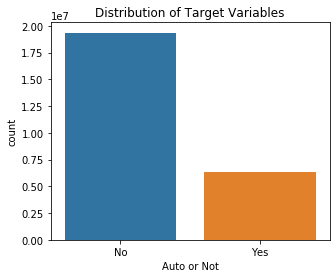

In [9]:
import seaborn as sns
sns.barplot(x="Auto or Not",y="count",data=imbalance_classes)
plt.title("Distribution of Target Variables")

In [10]:
train_idx=th.nonzero(train_mask_binary_label.squeeze()).numpy()
val_idx=th.nonzero(val_mask_binary_label.squeeze()).numpy()
test_idx=th.nonzero(test_mask_binary_label.squeeze()).numpy()

train_idx=th.from_numpy(train_idx).squeeze()    
val_idx=th.from_numpy(val_idx).squeeze()    
test_idx=th.from_numpy(test_idx).squeeze()

label_train=binary_label[train_idx].squeeze().numpy()
label_val=binary_label[val_idx].squeeze().numpy()
label_test=binary_label[test_idx].squeeze().numpy()


print('{:<15} {:<10,}'.format("Training set",train_idx.shape[0]))
print('{:<15} {:<10,}'.format("validation set",val_idx.shape[0]))
print('{:<15} {:<10,}'.format("test set",test_idx.shape[0]))

Training set    20,534,804
validation set  2,566,850 
test set        2,566,850 


In [11]:
##### check cuda
device="cpu"
use_cuda=args.gpu>=0 and th.cuda.is_available()
if use_cuda:
    th.cuda.set_device(args.gpu)
    device='cuda:%d' % args.gpu
print(device)

cuda:0


In [12]:
num_classes=th.unique(th.from_numpy(label_train)).shape[0]
if args.loss_weight:
    train_classes_num, train_classes_weight = get_class_count_weight(label_train,num_classes)
    loss_weight=th.tensor(train_classes_weight).to(device)
else:
    loss_weight=None

In [13]:
node_dict = {}
edge_dict = {}
for ntype in G.ntypes:
    node_dict[ntype] = len(node_dict)
for etype in G.etypes:
    edge_dict[etype] = len(edge_dict)
    G.edges[etype].data['id'] = th.ones(G.number_of_edges(etype), dtype=th.long) * edge_dict[etype] 

print(node_dict)
print(edge_dict)

{'usaanr': 0}
{'AUTO_RELATED': 0, 'Brother_Sister': 1, 'Busi_rel_Other': 2, 'Child': 3, 'Ex-Spouse': 4, 'Parent': 5, 'Pers_rel_Other': 6, 'SPONSEE': 7, 'SPONSOR': 8, 'Spouse': 9, 'Step-Child': 10, 'Step-Parent': 11}


In [14]:
for etype in G.etypes:
    for key,val in G.edges[etype].data.items():
        if key=="id":
            print("{:<15}{:<10}{:<10}".format(etype,key,th.unique(val).item()))

AUTO_RELATED   id        0         
Brother_Sister id        1         
Busi_rel_Other id        2         
Child          id        3         
Ex-Spouse      id        4         
Parent         id        5         
Pers_rel_Other id        6         
SPONSEE        id        7         
SPONSOR        id        8         
Spouse         id        9         
Step-Child     id        10        
Step-Parent    id        11        


In [15]:
model = HGT(G,
            node_dict, 
            edge_dict,
            in_feat=args.h_dim,
            h_dim=args.h_dim,
            out_feat=num_classes,
            n_layers=args.num_layers,
            n_heads=args.n_head,
            use_norm = True)

if use_cuda:
    model.cuda()

model.gcs

ModuleList(
  (0): HGTLayer(
    (k_linears): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (q_linears): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (v_linears): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (a_linears): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (norms): ModuleList(
      (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (drop): Dropout(p=0.2, inplace=False)
  )
  (1): HGTLayer(
    (k_linears): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (q_linears): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (v_linears): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (a_linears): ModuleList(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (norms): ModuleList(
      (0): L

In [16]:
# optimizer = th.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2norm)
# optimizer = th.optim.AdamW(model.parameters())
optimizer = th.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2norm)
### the number of n_epochs affects the learning rate, therefore affecting model evaluation results.
scheduler = th.optim.lr_scheduler.OneCycleLR(optimizer, total_steps=args.n_epochs, max_lr = args.max_lr)

In [17]:
# train sampler
train_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
train_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': train_idx}, train_sampler,
    batch_size=args.batch_size, shuffle=True, num_workers=args.num_worker)
# validation sampler
# we do not use full neighbor to save computation resources
val_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
val_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': val_idx}, val_sampler,
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)

test_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
test_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': test_idx}, test_sampler,
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)

print("The number of minibatch in training set is {:,}".format(len(train_loader)))
print("The number of minibatch in validation set is {:,}".format(len(val_loader)))
print("The number of minibatch in test set is {:,}".format(len(test_loader)))

The number of minibatch in training set is 2,006
The number of minibatch in validation set is 251
The number of minibatch in test set is 251


In [18]:
print("The total # of parameter is {:,}".format(sum([p.nelement() for p in model.parameters()]) ) )

The total # of parameter is 104,164


In [19]:
param_dict={n: p.nelement() for n, p in model.named_parameters()}
for i,j in param_dict.items():
    print("{:<70}{:<15,}".format(i,j))

gcs.0.relation_pri                                                    48             
gcs.0.relation_att                                                    12,288         
gcs.0.relation_msg                                                    12,288         
gcs.0.skip                                                            1              
gcs.0.k_linears.0.weight                                              4,096          
gcs.0.k_linears.0.bias                                                64             
gcs.0.q_linears.0.weight                                              4,096          
gcs.0.q_linears.0.bias                                                64             
gcs.0.v_linears.0.weight                                              4,096          
gcs.0.v_linears.0.bias                                                64             
gcs.0.a_linears.0.weight                                              4,096          
gcs.0.a_linears.0.bias                                

In [20]:
%pdb
LOSS_EPOCH=[]
LABEL_TRAIN=[]

# training loop
print("start training...")

total_loss=0
losses=[]

LOGIT_train=[]
LABEL_train=[]

# th.manual_seed(args.seed)
# th.cuda.manual_seed(args.seed)
# th.cuda.manual_seed_all(args.seed)
# np.ranom.seed(args.seed)
# random.seed(args.seed)
# th.backends.cudnn.deterministic=True

for epoch in tqdm(range(0,args.n_epochs)):
    
    model.train()
    IDX=[]
    H=[]
    
    #====================================#
    #            Traning                 #
    #====================================#
    print("")
    print("========= Epoch {:} /{:}".format(epoch+1,args.n_epochs))
    print("Training...")
    t0 = time.time()
    for step, (input_nodes_raw, seeds_raw, blocks) in enumerate(train_loader):
        blocks = [blk.to(device) for blk in blocks]
        
        seeds=seeds_raw.to(device)
        
        labels_train=binary_label[seeds].to(device)       
        
        input_nodes={}
        input_nodes["usaanr"]=input_nodes_raw
        input_nodes={k : e.to(device) for k, e in input_nodes.items()}
        
        logits,h = model(input_nodes,blocks)
        optimizer.zero_grad()
    
        if args.loss_weight :
            loss = F.cross_entropy(logits.view(-1, num_classes), labels_train.squeeze().to(device))
        else:
            loss = F.cross_entropy(logits.view(-1, num_classes), labels_train.squeeze().to(device),weight=loss_weight.to(device))
        
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        arg1=logits[:,1].detach().cpu().numpy()
        arg2=labels_train.cpu().numpy()
                
        train_gain = lift_gain_eval(arg1,arg2,topk=[0.01,0.05,0.10])
        
        train_acc = th.sum(logits.argmax(dim=1) == labels_train).item() / len(seeds)
        precision, recall, fscore, support = precision_recall_fscore_support(labels_train.cpu().numpy(), logits.argmax(dim=1).cpu().numpy())

        try:
            train_auc = roc_auc_score(labels_train.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
        except ValueError:
            pass
        
        prec,rec,_ = precision_recall_curve(labels_train.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
        if math.isnan(rec[0])==False:
            train_pr_auc=auc_score(rec,prec)

        IDX.extend(seeds.detach().cpu().numpy().tolist())
        H.extend(h.detach().cpu().numpy().tolist())
        LOGIT_train.extend(logits.detach().cpu().numpy().tolist())
        LABEL_train.extend(binary_label[blocks[-1].dstnodes['usaanr'].data[dgl.NID].cpu().numpy()].tolist())
        
        if step%(len(train_loader)//10)==0 and not step==0:

            t1 = time.time()
            elapsed=utils.format_time(t1-t0)
            print("Batch {:} of {:} | Loss {:.3f}  | Elapsed: {:}".\
                  format(step,len(train_loader),np.mean(losses[-10:]),elapsed)) 
            
    LOSS_EPOCH.append(loss)

    LABEL_TRAIN.append(binary_label[blocks[-1].nodes['usaanr'].data[dgl.NID].cpu().numpy()])


    model.eval()
    print()
    print("")
    print("Running Validation on training set")
    print("")
    fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, train_loader, binary_label,  device, loss_weight, num_classes)
    
    avg_loss_train=np.mean(losses_tmp)
    
    tmp_mean_pool_train=evaluate(fin_targets.reshape(-1),fin_outputs)
    
    t2=time.time()
    
    print("avg_loss: {:.2f} | True_Prediction: {:,} | False_Prediction: {:,} | accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-10%: {:.1f} |\
    ROC_AUC: {:.1%} | PR_AUC: {:.1%} | Elapsed: {:}".format(avg_loss_train, tmp_mean_pool_train["true_prediction"], tmp_mean_pool_train["false_prediction"], tmp_mean_pool_train["accuracy"], \
                                                            tmp_mean_pool_train["precision"], tmp_mean_pool_train["recall"], tmp_mean_pool_train["f1_score"], tmp_mean_pool_train["GAIN"]['10%'], \
                                                            tmp_mean_pool_train["AUC"], tmp_mean_pool_train["pr_auc"], utils.format_time(t2-t1)))

    #====================================#
    #            Validation-set          #
    #====================================#
    
    model.eval()
    print()
    print("")
    print("Running Validation on validation set")
    print("")
    
    fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, val_loader, binary_label,  device, loss_weight, num_classes)
    
    avg_loss_val=np.mean(losses_tmp)
    
    tmp_mean_pool_val=evaluate(fin_targets.reshape(-1),fin_outputs)
    
    t3=time.time()
    
    print("avg_loss: {:.2f} | True_Prediction: {:,} | False_Prediction: {:,} | accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-10%: {:.1f} |\
    ROC_AUC: {:.1%} | PR_AUC: {:.1%} | Elapsed: {:}".format(avg_loss_val, tmp_mean_pool_val["true_prediction"], tmp_mean_pool_val["false_prediction"], tmp_mean_pool_val["accuracy"], \
                                                            tmp_mean_pool_val["precision"], tmp_mean_pool_val["recall"], tmp_mean_pool_val["f1_score"], tmp_mean_pool_val["GAIN"]['10%'], \
                                                            tmp_mean_pool_val["AUC"], tmp_mean_pool_val["pr_auc"], utils.format_time(t3-t2)))
    
# if args.model_path is not None:
#     th.save(model.state_dict(), args.model_path)
    
#====================================#
#            Test-set                #
#====================================#
print()
print("")
print("Running Validation in Test Dataset")
print("")
model.eval()

fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, test_loader, binary_label,  device, loss_weight, num_classes)
    
avg_loss_test=np.mean(losses_tmp)

tmp_mean_pool_test=evaluate(fin_targets.reshape(-1),fin_outputs)

t4=time.time()

print("avg_loss: {:.2f} | True_Prediction: {:,} | False_Prediction: {:,} | accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-10%: {:.1f} |\
ROC_AUC: {:.1%} | PR_AUC: {:.1%} | Elapsed: {:}".format(avg_loss_test, tmp_mean_pool_test["true_prediction"], tmp_mean_pool_test["false_prediction"], tmp_mean_pool_test["accuracy"], \
                                                        tmp_mean_pool_test["precision"], tmp_mean_pool_test["recall"], tmp_mean_pool_test["f1_score"], tmp_mean_pool_test["GAIN"]['10%'], \
                                                        tmp_mean_pool_test["AUC"], tmp_mean_pool_test["pr_auc"], utils.format_time(t4-t3)))


  0%|          | 0/3 [00:00<?, ?it/s]

Automatic pdb calling has been turned ON
start training...

========= Epoch 1 /3
Training...
Batch 200 of 2006 | Loss 0.389  | Elapsed: 0:02:58
Batch 400 of 2006 | Loss 0.383  | Elapsed: 0:05:28
Batch 600 of 2006 | Loss 0.377  | Elapsed: 0:07:54
Batch 800 of 2006 | Loss 0.375  | Elapsed: 0:10:20
Batch 1000 of 2006 | Loss 0.369  | Elapsed: 0:12:50
Batch 1200 of 2006 | Loss 0.369  | Elapsed: 0:15:07
Batch 1400 of 2006 | Loss 0.371  | Elapsed: 0:17:36
Batch 1600 of 2006 | Loss 0.368  | Elapsed: 0:20:02
Batch 1800 of 2006 | Loss 0.365  | Elapsed: 0:22:32
Batch 2000 of 2006 | Loss 0.367  | Elapsed: 0:25:09


  0%|          | 0/2006 [00:00<?, ?it/s]



Running Validation on training set



  0%|          | 0/251 [00:00<?, ?it/s]

avg_loss: 0.49 | True_Prediction: 16,860,255 | False_Prediction: 3,674,549 | accuracy: 82.11% |  precision: 65.57% | recall: 57.27% | F1_score: 61.14% | Gain_top-10%: 0.3 |    ROC_AUC: 87.0% | PR_AUC: 67.3% | Elapsed: 0:10:26


Running Validation on validation set



 33%|███▎      | 1/3 [36:45<1:13:30, 2205.37s/it]

avg_loss: 0.49 | True_Prediction: 2,107,423 | False_Prediction: 459,427 | accuracy: 82.10% |  precision: 65.57% | recall: 57.23% | F1_score: 61.12% | Gain_top-10%: 0.3 |    ROC_AUC: 87.0% | PR_AUC: 67.4% | Elapsed: 0:01:11

========= Epoch 2 /3
Training...
Batch 200 of 2006 | Loss 0.367  | Elapsed: 0:02:12
Batch 400 of 2006 | Loss 0.366  | Elapsed: 0:04:25
Batch 600 of 2006 | Loss 0.364  | Elapsed: 0:06:28
Batch 800 of 2006 | Loss 0.366  | Elapsed: 0:08:43
Batch 1000 of 2006 | Loss 0.361  | Elapsed: 0:11:05
Batch 1200 of 2006 | Loss 0.366  | Elapsed: 0:13:16
Batch 1400 of 2006 | Loss 0.364  | Elapsed: 0:15:46
Batch 1600 of 2006 | Loss 0.362  | Elapsed: 0:17:57
Batch 1800 of 2006 | Loss 0.364  | Elapsed: 0:20:37
Batch 2000 of 2006 | Loss 0.365  | Elapsed: 0:22:51


  0%|          | 0/2006 [00:00<?, ?it/s]



Running Validation on training set



  0%|          | 0/251 [00:00<?, ?it/s]

avg_loss: 0.52 | True_Prediction: 16,928,910 | False_Prediction: 3,605,894 | accuracy: 82.44% |  precision: 69.29% | recall: 51.29% | F1_score: 58.95% | Gain_top-10%: 0.3 |    ROC_AUC: 87.5% | PR_AUC: 68.4% | Elapsed: 0:10:41


Running Validation on validation set



 67%|██████▋   | 2/3 [1:12:12<36:21, 2181.91s/it]

avg_loss: 0.52 | True_Prediction: 2,116,397 | False_Prediction: 450,453 | accuracy: 82.45% |  precision: 69.35% | recall: 51.27% | F1_score: 58.95% | Gain_top-10%: 0.3 |    ROC_AUC: 87.5% | PR_AUC: 68.5% | Elapsed: 0:01:11

========= Epoch 3 /3
Training...
Batch 200 of 2006 | Loss 0.363  | Elapsed: 0:02:09
Batch 400 of 2006 | Loss 0.363  | Elapsed: 0:04:25
Batch 600 of 2006 | Loss 0.366  | Elapsed: 0:06:30
Batch 800 of 2006 | Loss 0.362  | Elapsed: 0:08:52
Batch 1000 of 2006 | Loss 0.362  | Elapsed: 0:10:57
Batch 1200 of 2006 | Loss 0.362  | Elapsed: 0:13:04
Batch 1400 of 2006 | Loss 0.365  | Elapsed: 0:15:36
Batch 1600 of 2006 | Loss 0.364  | Elapsed: 0:17:44
Batch 1800 of 2006 | Loss 0.362  | Elapsed: 0:19:51
Batch 2000 of 2006 | Loss 0.365  | Elapsed: 0:22:37


  0%|          | 0/2006 [00:00<?, ?it/s]



Running Validation on training set



  0%|          | 0/251 [00:00<?, ?it/s]

avg_loss: 0.51 | True_Prediction: 16,927,053 | False_Prediction: 3,607,751 | accuracy: 82.43% |  precision: 67.76% | recall: 54.42% | F1_score: 60.36% | Gain_top-10%: 0.3 |    ROC_AUC: 87.5% | PR_AUC: 68.4% | Elapsed: 0:09:23


Running Validation on validation set



  0%|          | 0/251 [00:00<?, ?it/s]

avg_loss: 0.51 | True_Prediction: 2,115,734 | False_Prediction: 451,116 | accuracy: 82.43% |  precision: 67.77% | recall: 54.36% | F1_score: 60.33% | Gain_top-10%: 0.3 |    ROC_AUC: 87.5% | PR_AUC: 68.5% | Elapsed: 0:00:58


Running Validation in Test Dataset



100%|██████████| 251/251 [00:50<00:00,  4.92it/s]


avg_loss: 0.51 | True_Prediction: 2,116,481 | False_Prediction: 450,369 | accuracy: 82.45% |  precision: 67.80% | recall: 54.52% | F1_score: 60.44% | Gain_top-10%: 0.3 |ROC_AUC: 87.5% | PR_AUC: 68.4% | Elapsed: 0:01:04


In [21]:
tmp_mean_pool_train

{'nb_example': 20534804,
 'true_prediction': 16927053,
 'false_prediction': 3607751,
 'accuracy': 0.8243104243897337,
 'precision': 0.6775846002132118,
 'recall': 0.5442218622323594,
 'f1_score': 0.6036248199406297,
 'AUC': 0.875024867957377,
 'pr_auc': 0.6837390084566433,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.32}}

In [22]:
tmp_mean_pool_val

{'nb_example': 2566850,
 'true_prediction': 2115734,
 'false_prediction': 451116,
 'accuracy': 0.82425307283246,
 'precision': 0.6776574579522712,
 'recall': 0.5436121839929378,
 'f1_score': 0.6032784866899421,
 'AUC': 0.8750637208082545,
 'pr_auc': 0.684522840543195,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.32}}

In [23]:
tmp_mean_pool_test

{'nb_example': 2566850,
 'true_prediction': 2116481,
 'false_prediction': 450369,
 'accuracy': 0.8245440910064865,
 'precision': 0.6779702775149795,
 'recall': 0.5451622054681842,
 'f1_score': 0.604356072419067,
 'AUC': 0.8751656074330677,
 'pr_auc': 0.6840378897340809,
 'GAIN': {'1%': 0.04, '5%': 0.17, '10%': 0.32}}

#### model save

In [24]:
# if not os.path.exists("model_save"):
#     os.makedirs("model_save")
# model.save_model("model_save/HGT")

#### Score Test Dataset

In [ ]:
# %%time
# fin_outputs, fin_targets, losses_tmp=eval_loop_func(model, test_loader, binary_label,  device, loss_weight, num_classes)

# savez_compressed("model_save/HGT_LOGIT.npz", fin_outputs)
# savez_compressed("model_save/HGT_LABEL.npz", fin_targets)

# # os.system("rm model_save/HGT_LOGIT.npz")
# # os.system("rm model_save/HGT_LABEL.npz")

# fin_logits = load("model_save/HGT_LOGIT.npz")['arr_0']
# fin_targets = load("model_save/HGT_LABEL.npz")['arr_0']

# tmp_test=evaluate(fin_targets.reshape(-1),fin_logits)

# print("")
# print("==> Running Validation on validation set \n")
# print("")

# print("True_Prediction: {:,} | False_Prediction: {:,} | accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-10%: {:.1f} |\
# ROC_AUC: {:.1%} | PR_AUC: {:.1%}".format(tmp_test["true_prediction"], tmp_test["false_prediction"], tmp_test["accuracy"], \
#                                                         tmp_test["precision"], tmp_test["recall"], tmp_test["f1_score"], tmp_test["GAIN"]['10%'], \
#                                                         tmp_test["AUC"], tmp_test["pr_auc"]))

In [ ]:
model

In [ ]:
model.state_dict()tt